# How long is a day?
In this tutorial we will use an astronomical Python library to show how the length of a day varies during one year. Let's start from importing the ephem module and instantiating an observer:

In [1]:
import ephem
observer = ephem.Observer()

To set observer's localization we have to set the position on the Earth's surface:

In [2]:
observer.lat = "51.109454"
observer.lon = "17.032686"
observer.elev = 120
observer

<ephem.Observer date='2017/10/2 18:34:33' epoch='2000/1/1 12:00:00' lon='17:01:57.7' lat='51:06:34.0' elevation=120.0m horizon=0:00:00.0 temp=15.0C pressure=1010.0mBar>

We can see that the observer is related with a date when the object was created. We need all days in one year, so a good choice is to use the pandas module and its fixed frequency datetime index for the current year:

In [3]:
import pandas as pd

current_year = observer.date.triple()[0]
all_days = pd.date_range(str(current_year) + "/01/01", str(current_year) + "/12/31")
all_days

DatetimeIndex(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
               '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08',
               '2017-01-09', '2017-01-10',
               ...
               '2017-12-22', '2017-12-23', '2017-12-24', '2017-12-25',
               '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29',
               '2017-12-30', '2017-12-31'],
              dtype='datetime64[ns]', length=365, freq='D')

To calculate the length of a specific day we have to estimate time between the Sun rising and setting:

In [4]:
sun = ephem.Sun()
day_length = []

for ad in all_days:
    observer.date = ad
    day_length += [observer.next_setting(sun) - observer.next_rising(sun)]
    
days = 24.*pd.DataFrame(day_length, index=all_days, columns=["day_length"])
days.head()

,day_length
2017-01-01,8.017117
2017-01-02,8.037027
2017-01-03,8.058562
2017-01-04,8.081697
2017-01-05,8.106407


It's time to visualize obtained results. To do this we will use the matplotlib library:

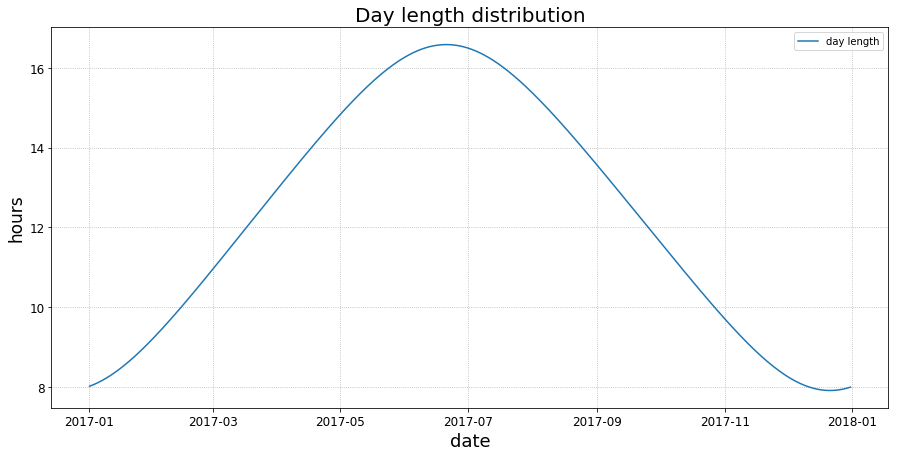

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,7))
plt.plot(days.index, days.values)
plt.title('Day length distribution', fontsize=20)
plt.xlabel('date', fontsize=18)
plt.ylabel('hours', fontsize=17)
plt.tick_params(labelsize=12)
plt.grid(linestyle='dotted')
plt.legend(('day length',))
plt.show()

We can see that the curve increases and decreases the most rapidly around both equinoxes. It means that people can notice changes week-by-week. There is additional interesting feature on the plot. Let's draw a similar function for nights. We know that a day lasts 24 hours, so we can quickly compute the length of each night:

In [6]:
days["night_length"] = 24. - days["day_length"]
days.head(3)

,day_length,night_length
2017-01-01,8.017117,15.982883
2017-01-02,8.037027,15.962973
2017-01-03,8.058562,15.941438


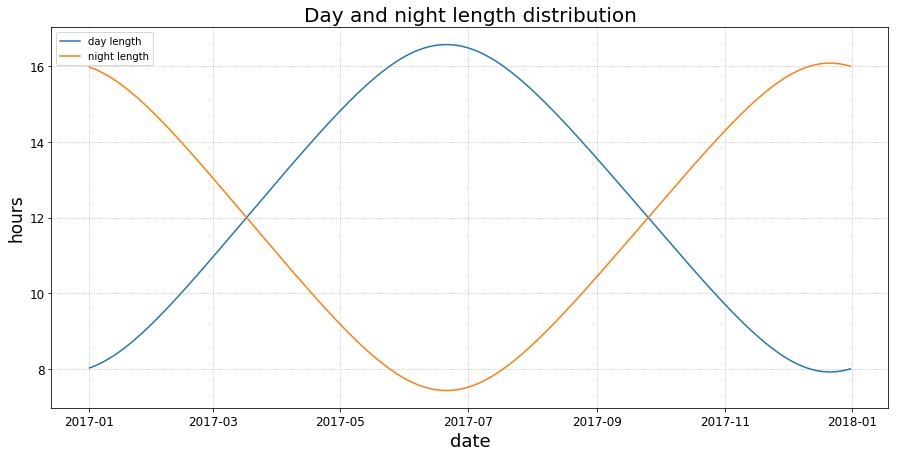

In [7]:
plt.figure(figsize=(15,7))
plt.title('Day and night length distribution', fontsize=20)
plt.plot(days.index, days["day_length"])
plt.plot(days.index, days["night_length"])
plt.xlabel('date', fontsize=18)
plt.ylabel('hours', fontsize=17)
plt.tick_params(labelsize=12)
plt.grid(linestyle='dotted')
plt.legend(('day length','night length'))
plt.show()

We see that the longest day is longer than the longest night. Let's sum the lengths of days and nights and compare their difference:

In [8]:
sum_diff = (days["day_length"].sum() - days["night_length"].sum())/24. # in days
sum_diff

8.6215135094535071

Intuitively it seems that the length of all days and all nights should be equal because the Earth's movements are symmetrical. As we can see it's not true. This phenomenon is mainly caused by atmospheric refraction which shifts up a position of the Sun near the horizon. Additional contribution comes from the fact that the Sun isn't a point but an extended source. Sunsets and sunrises are defined as the moments when the upper limb of the Sun passes the horizon line rather than the geometric center of a body. Let's switch off refraction and define sunrise and sunset as a moment when the center of the Sun crosses the horizon:

In [9]:
day_length_mod = []

for ad in all_days:
    sun.compute(ad)
    observer.date = ad
    observer.pressure = 0 # remove atmospheric refraction
    observer.horizon = sun.radius # center point instead of the upper limb of the Sun
    day_length_mod += [observer.next_setting(sun) - observer.next_rising(sun)]
    
days_mod = 24.*pd.DataFrame(day_length_mod, index=all_days, columns=["day_length"])
days_mod["night_length"] = 24. - days_mod["day_length"]
days_mod.head(3)

,day_length,night_length
2017-01-01,7.777360,16.222640
2017-01-02,7.797804,16.202196
2017-01-03,7.819913,16.180087


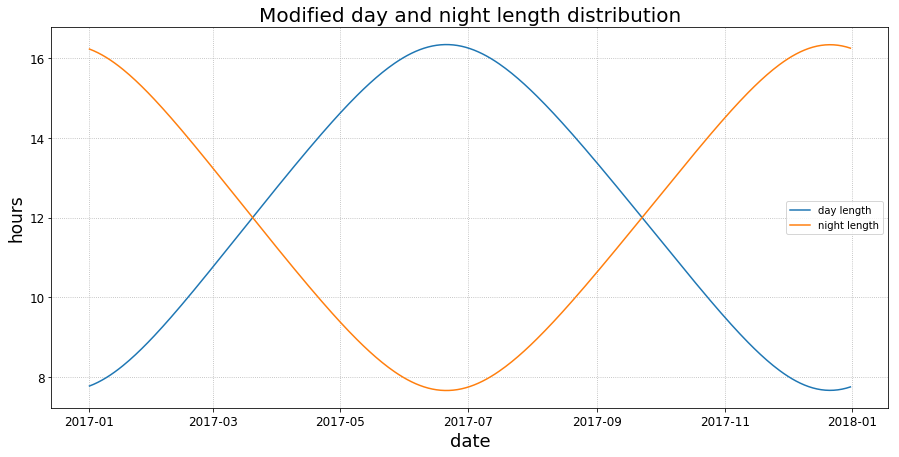

In [10]:
plt.figure(figsize=(15,7))
plt.title('Modified day and night length distribution', fontsize=20)
plt.plot(days_mod.index, days_mod["day_length"])
plt.plot(days_mod.index, days_mod["night_length"])
plt.xlabel('date', fontsize=18)
plt.ylabel('hours', fontsize=17)
plt.tick_params(labelsize=12)
plt.grid(linestyle='dotted')
plt.legend(('day length','night length'))
plt.show()